In [31]:
from pyspark import *
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
import pickle
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
from pyspark.ml.classification import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sparkhistogram import computeHistogram
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import col, cast

In [32]:
spark = SparkSession.builder.appName("My App").getOrCreate()
df = spark.read.csv("train_u6lujuX_CVtuZ9i.csv", header=True)
df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|                0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|             1508|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|                0|        66|             360|             1|        Urban|          Y

In [33]:

df = df.withColumn("ApplicantIncome",df["ApplicantIncome"].cast('float'))
df = df.withColumn("CoapplicantIncome",df["CoapplicantIncome"].cast('float'))
df = df.withColumn("LoanAmount",df["LoanAmount"].cast('float'))
df = df.withColumn("Loan_Amount_Term",df["Loan_Amount_Term"].cast('float'))
df = df.withColumn("Credit_History",df["Credit_History"].cast('float'))

In [34]:
# Sélectionnez les colonnes quantitatives
quantitative_columns = [c for c, t in df.dtypes if t=='float']
quantitative_df = df.select(quantitative_columns)

# Sélectionnez les colonnes qualitatives
qualitative_columns = [c for c, t in df.dtypes if t!='float']
qualitative_df = df.select(qualitative_columns)
# Afficher le nombre de lignes

In [35]:
#replace missing values
from pyspark.sql.functions import col, count, when
for c, t in qualitative_df.dtypes:
    most_frequent_value =\
    qualitative_df.select(c).groupBy(c).count().orderBy(count(c).desc()).first()[0]
    # Remplacer les valeurs manquantes dans la colonne par la valeur la plus fréquente
    qualitative_df =qualitative_df.withColumn(c, when(col(c).isNull(), most_frequent_value).otherwise(col(c)))

for c, t in quantitative_df.dtypes:
    most_frequent_value = \
        quantitative_df.select(c).groupBy(c).count().orderBy(count(c).desc()).first()[0]
    # Remplacer les valeurs manquantes dans la colonne par la valeur la plus fréquente
    quantitative_df = quantitative_df.withColumn(c, when(col(c).isNull(), most_frequent_value).otherwise(col(c)))

In [36]:
for c, t in qualitative_df.dtypes:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_")
    qualitative_df = indexer.fit(qualitative_df).transform(qualitative_df)
    qualitative_df = qualitative_df.drop(c)

c:\Python\Python310\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


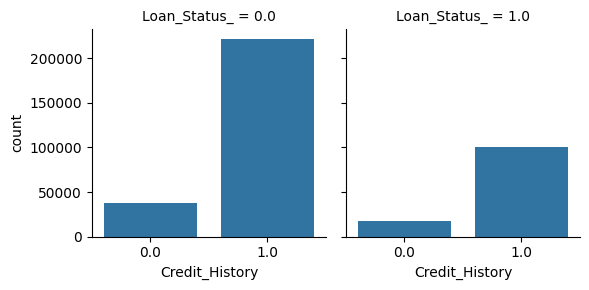

In [47]:
X=qualitative_df.join(quantitative_df,on=None,how="outer")
X=X.drop("Loan_ID_")
X_copy=X.toPandas()
g = sns.FacetGrid(X_copy, col="Loan_Status_")
g = g.map(sns.countplot,"Credit_History")

plt.savefig("loan_status_Credit_History.png", bbox_inches='tight', dpi=100)
plt.show()

c:\Python\Python310\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


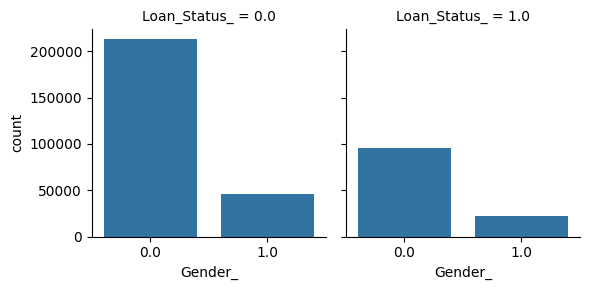

In [48]:
 
g = sns.FacetGrid(X_copy, col="Loan_Status_")
g = g.map(sns.countplot,"Gender_")

plt.savefig("loan_status_ Gender.png", bbox_inches='tight', dpi=100)
plt.show()

c:\Python\Python310\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


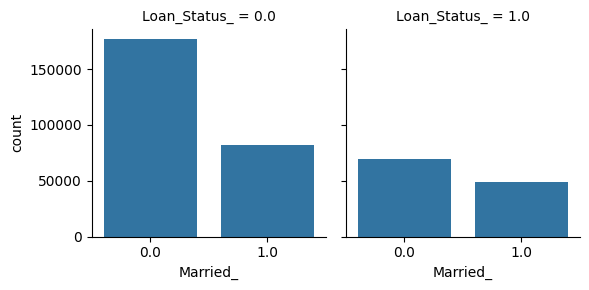

In [49]:

X_copy=X.toPandas()
g = sns.FacetGrid(X_copy, col="Loan_Status_")
g = g.map(sns.countplot,"Married_")

plt.savefig("loan_status_ Married.png", bbox_inches='tight', dpi=100)
plt.show()

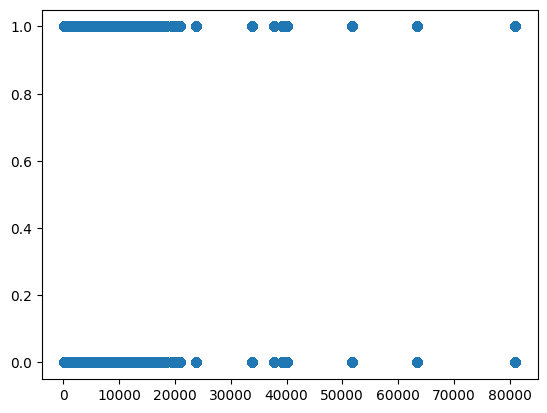

In [50]:
plt.scatter(X_copy['ApplicantIncome'],X_copy['Loan_Status_'])

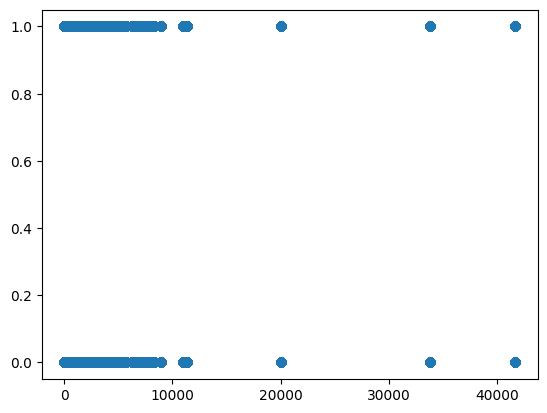

In [51]:
plt.scatter(X_copy['CoapplicantIncome'],X_copy['Loan_Status_'])

In [61]:
assembler=VectorAssembler(inputCols=['ApplicantIncome','CoapplicantIncome','Married_','Credit_History'],outputCol="features")
output=assembler.transform(X)
model=output.select("features","Loan_Status_")
model_train,model_test=model.randomSplit([0.7,0.3])
df_classifier=DecisionTreeClassifier(labelCol="Loan_Status_")
r=df_classifier.fit(model_train)
df_predictions=r.transform(model_test)
df_accuracy=MulticlassClassificationEvaluator(labelCol="Loan_Status_",metricName="accuracy").evaluate(df_predictions)
 

In [ ]:
pickle.dump(r,open('model.pkl','wb') )